In [2]:
import pandas as pd
import numpy as np
import os
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns

import nltk.sentiment.util
from nltk.corpus import stopwords
from Stemmer import Stemmer
from nltk.stem.snowball import SnowballStemmer # do not use
from sklearn.feature_extraction.text import CountVectorizer

from linearmodels import PanelOLS

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import KFold

from sklearn.decomposition import LatentDirichletAllocation as LDA
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity

In [106]:
sns.set_theme(palette='RdBu', style='darkgrid')

In [5]:
data_dir = "../../data/"

# Question 1

In [6]:
guid_map = pd.read_csv(data_dir + 'map_file.csv', parse_dates = ['trade_date'])
rets_daily = pd.read_csv(data_dir + 'rets_daily.csv', parse_dates = ['date'])
info = pd.read_csv(data_dir + 'infos.csv')
# Stop words
reuters_stopwords = pd.read_csv(data_dir + "reuters_stopwords.csv")

In [8]:
id_info = (pd.merge(guid_map, info, on=["Id"], how='right') # merge articles on permnos & dates
      .query("in_sp == 1 and in_sp_tm5 == 1") # keep only S&P 500 firms
      .drop_duplicates(subset=["Id", "augmented body"])) # Select the unique Id and augmented body pair

In [9]:
analyzer = CountVectorizer().build_analyzer()

# Create a set of stop words
en_stemmer = Stemmer("en")
stop_words = stopwords.words("english") + reuters_stopwords.values.flatten().tolist() # nltk, reuters
sw = set( analyzer(' '.join(stop_words))
         + analyzer(' '.join(en_stemmer.stemWords(stop_words)))
        ) # nltk, reuters, Stemmer.Stemmer

# Remove all digits from the text string.
#  Make a custom stemming function that uses the English stemmer from PyStemmer
def stemmed_words(txt):
    return en_stemmer.stemWords( analyzer( re.sub('[0-9]', ' ', txt) ) )

cv = CountVectorizer(tokenizer = stemmed_words, stop_words=sw)
dtm_raw = cv.fit_transform(id_info["augmented body"].tolist()) #

In [10]:
print(dtm_raw.shape) # It should also have 229,728 rows (or fairly close).

(229745, 211513)


In [11]:
# Obtain the top 1000 words over the whole sample. Keep only those words and drop all others.
freq = dtm_raw.sum(axis=0) # sum the count of words over articles
word_idx_freq = [(wrd, idx, freq[0, idx]) for wrd, idx in cv.vocabulary_.items()]
topWords_idx_freq = sorted(word_idx_freq, key = lambda x: x[2], reverse = True)[:1000]
topIdx = [el[1] for el in topWords_idx_freq]
dtm = dtm_raw[:,topIdx] # 

topWords = [el[0] for el in topWords_idx_freq]
dtm_frame = pd.DataFrame(dtm.toarray(), columns = topWords)
id_info.reset_index(drop=True, inplace=True) # !
dtm_frame["Id"] = id_info["Id"] # same # of rows

In [12]:
# Final dtm
df = (pd.merge(guid_map, dtm_frame, on="Id", how="right")  # Merge back in the rows with the firm IDs and trade dates
    .query("in_sp==1 and in_sp_tm5==1")
    .drop(["in_sp", "in_sp_tm5"], axis=1)
    .groupby(["permno", "trade_date"]).sum()) # firm-day level

/var/folders/6q/bp8zcmjx7_d5s99yfjlq82540000gn/T/ipykernel_3993/1696739230.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = (pd.merge(guid_map, dtm_frame, on="Id", how="right")  # Merge back in the rows with the firm IDs and trade dates


In [13]:
print(df.shape) # should have 147,519 rows (or fairly close)

(147535, 1000)


In [10]:
df.to_pickle('final_dtm.pkl')

# Question 2

## (a)

In [14]:
# Scale your DTM to be in terms of frequencies (each row sums to one)
# but save the raw counts for the LDA estimation later
scaled_df = df.div(df.sum(axis=1), axis=0)
# Scale each column to have the same (e.g., unit) variance
scaled_df = scaled_df.div(scaled_df.std(axis=1), axis=0)

In [18]:
rets_daily.rename(columns={"date": "trade_date"}, inplace=True)
rets_daily_wide = rets_daily.pivot(index = "trade_date", columns = 'permno', values = 'ret')

rets_daily.rename(columns={"date": "trade_date"}, inplace=True) # "date" in dtm columns

rets_daily_tm10_tm1 = (
        (1+rets_daily_wide)
        .rolling(10)
        .apply(np.prod, raw=True)
        .shift(1)
        -1 ).unstack().rename('ret_tm10_tm1').reset_index()

rets_daily_tp1 = (
    rets_daily_wide
    .shift(-1)
    .unstack()
    .rename('ret_tp1')
    .reset_index() 
)

ret_data = (rets_daily
            .merge(rets_daily_tp1, on = ['permno','trade_date'])
            .merge(rets_daily_tm10_tm1, on = ['permno','trade_date'])
            .query('in_sp==1 and in_sp_tm5==1')
            .dropna(subset=["ret"]))

ret_data = ret_data[['permno', 'trade_date',  'ret', 'ret_tp1', 'ret_tm10_tm1']] # (147519,)

In [20]:
ret_data.head()

,permno,trade_date,ret,ret_tp1,ret_tm10_tm1
128,10078,1996-01-02,-0.019178,-0.078212,NaN
129,10078,1996-01-03,-0.078212,-0.018182,NaN
130,10078,1996-01-04,-0.018182,0.000000,NaN
131,10078,1996-01-05,0.000000,-0.009259,NaN
132,10078,1996-01-08,-0.009259,-0.068536,NaN


In [21]:
lasso_data = pd.merge(ret_data, scaled_df.reset_index(), 
         on = ["permno", "trade_date"],
         how = "right").dropna(subset=["ret"])

y = lasso_data["ret"]
X = lasso_data[topWords]
# The left-hand side variable in your estimation 
# will be the contemporaneous returns on the day of the article release t.

In [22]:
# https://towardsdatascience.com/hyperparameter-tuning-in-lasso-and-ridge-regressions-70a4b158ae6d

# CV to determine hyperparamter
mod = Lasso(fit_intercept=True)
alpha_grid = {"alpha": np.linspace(1e-5, 1e-2,50)}
gscv = GridSearchCV(mod,
             param_grid = alpha_grid,
             scoring = 'neg_mean_absolute_error',
             return_train_score = True,
             cv = 3,
             n_jobs = -1,
             error_score='raise', verbose=3)
res_cv = gscv.fit(X,y) # 3-Fold CV results
best_alpha = res_cv.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 3/3] END alpha=0.0004177551020408164;, score=(train=-0.016, test=-0.018) total time=  20.3s
[CV 2/3] END alpha=0.0004177551020408164;, score=(train=-0.016, test=-0.017) total time=  20.4s
[CV 1/3] END alpha=0.0004177551020408164;, score=(train=-0.017, test=-0.015) total time=  20.7s
[CV 1/3] END alpha=0.0006216326530612246;, score=(train=-0.017, test=-0.015) total time=  21.0s
[CV 2/3] END alpha=0.0002138775510204082;, score=(train=-0.016, test=-0.017) total time=  22.4s
[CV 3/3] END alpha=0.0002138775510204082;, score=(train=-0.016, test=-0.018) total time=  24.0s
[CV 1/3] END alpha=0.0002138775510204082;, score=(train=-0.017, test=-0.015) total time=  24.1s
[CV 2/3] END alpha=0.0008255102040816328;, score=(train=-0.016, test=-0.017) total time=   5.1s
[CV 2/3] END alpha=0.0006216326530612246;, score=(train=-0.016, test=-0.017) total time=   5.7s
[CV 3/3] END alpha=0.0006216326530612246;, score=(train=-0.016, test=-0.01

In [23]:
lasso = Lasso(alpha = best_alpha["alpha"], fit_intercept=True, random_state=0)
res = lasso.fit(X,y)

In [24]:
coefs = pd.Series(lasso.coef_, index=topWords)
# Report the non-zero coefficients from the estimation
print(coefs[coefs!=0])

price      -0.000042
share      -0.000006
billion     0.000013
rais        0.000126
cut        -0.000054
              ...   
nyse       -0.003153
upgrad      0.000696
covid       0.000691
downgrad   -0.000506
slump      -0.000266
Length: 72, dtype: float64


In [25]:
# Plot the mean monthly sentiment (i.e., text-implied returns from the model) over time
sent_pred = pd.DataFrame(lasso.predict(X), columns=["sent_pred"])
sent_pred["permno"] = lasso_data["permno"]
sent_pred["trade_date"] = lasso_data["trade_date"]

In [26]:
sent_pred['ym'] = sent_pred.trade_date.apply(lambda x: str(x.year) +'-'+str(x.month).zfill(2))
agg_sent_pred = sent_pred.groupby("ym")["sent_pred"].mean()

In [86]:
permno_sent = pd.read_pickle("../hw1/permno_sent.pkl")[["permno","trade_date","sent"]]
permno_sent["ym"] = permno_sent.trade_date.apply(lambda x: str(x.year) +'-'+str(x.month).zfill(2))
agg_lm_sent = permno_sent.groupby("ym")["sent"].mean()

In [97]:
agg_lasso_sent = sent_pred.groupby("ym")["sent_pred"].mean()

<AxesSubplot: xlabel='ym'>

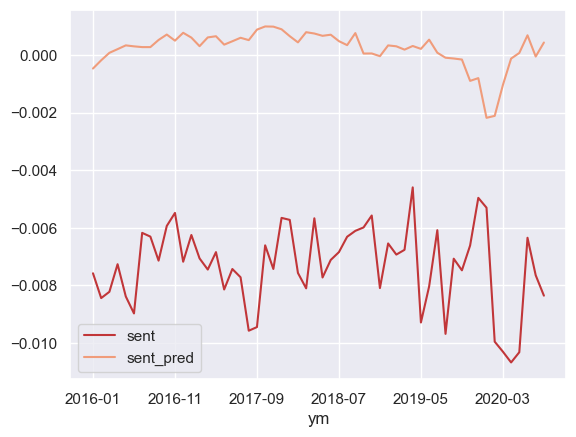

In [107]:
sent = pd.merge(agg_lm_sent.reset_index(), agg_lasso_sent.reset_index())
sent.set_index("ym").plot()

The implied sentiment is higher and less volatile than LM sentiment in homework1.

## (b)

In [27]:
lm_dict = pd.read_csv(data_dir + 'Loughran-McDonald_MasterDictionary_1993-2021.csv')
# lowercase
neg_lm = lm_dict.query('Negative>0').Word.str.lower().to_list()
pos_lm = lm_dict.query('Positive>0').Word.str.lower().to_list()
# Stem the words from the LM dictionary to make them comparable
pos_lm = set([stemmed_words(wrd)[0] for wrd in pos_lm])
neg_lm = set([stemmed_words(wrd)[0] for wrd in neg_lm])

In [28]:
# +/- coefficients
pos_coef = coefs[coefs.values>0].index.tolist()
neg_coef = coefs[coefs.values<0].index.tolist()

In [29]:
# Positive Lasso coefficients that are in the positive LM dictionary
print("Positive Lasso coefficients that are in the positive LM dictionary",
      set(pos_coef).intersection(pos_lm))
# Positive Lasso coefficients that are in the negative LM dictionary
print("Positive Lasso coefficients that are in the negative LM dictionary",
      set(pos_coef).intersection(neg_lm))
# Positive Lasso coefficients that are not in either LM dictionary
print("Positive Lasso coefficients that are not in either LM dictionary",
      set(pos_coef).difference(pos_lm).difference(neg_lm))
# Negative Lasso coefficients that are in the negative LM dictionary
print("Negative Lasso coefficients that are in the negative LM dictionary",
      set(neg_coef).intersection(neg_lm))
# Negative Lasso coefficients that are in the positive LM dictionary
print("Negative Lasso coefficients that are in the positive LM dictionary",
      set(neg_coef).intersection(pos_lm))
# Negative Lasso coefficients that are not in either LM dictionary
print("Negative Lasso coefficients that are not in either LM dictionary",
      set(neg_coef).difference(pos_lm).difference(neg_lm))


Positive Lasso coefficients that are in the positive LM dictionary {'boost', 'strong', 'gain', 'posit', 'better'}
Positive Lasso coefficients that are in the negative LM dictionary {'close'}
Positive Lasso coefficients that are not in either LM dictionary {'billion', 'tuesday', 'jump', 'deal', 'three', 'dividend', 'juli', 'rise', 'stake', 'gainer', 'rais', 'upgrad', 'new', 'beat', 'april', 'hope', 'premarket', 'announc', 'ralli', 'covid', 'surg', 'higher', 'high', 'million', 'rose', 'exchang', 'talk'}
Negative Lasso coefficients that are in the negative LM dictionary {'loss', 'cut', 'drop', 'downgrad', 'fear', 'miss'}
Negative Lasso coefficients that are in the positive LM dictionary set()
Negative Lasso coefficients that are not in either LM dictionary {'forecast', 'march', 'share', 'price', 'ceo', 'spread', 'slump', 'sale', 'oil', 'among', 'travel', 'slip', 'health', 'say', 'appl', 'energi', 'biggest', 'retail', 'loser', 'store', 'brand', 'coronavirus', 'industri', 'weigh', 'fall', '

## (c)

$ r_{i,t+1} = bsent_{i,t} + cr_{i,t} + dr_{i,t-10,t-1} + \epsilon_{i,t+1} + month_{t} + firm_{i} $

In [30]:
def sentRegression():
    reg_data = pd.merge(ret_data, sent_pred, how="inner",
                        on=["permno", "trade_date"])
    reg_data['yearmon'] = (reg_data['trade_date'] 
                           - pd.tseries.offsets.MonthEnd(1)
                           + pd.tseries.offsets.MonthEnd(1))
    reg_data.set_index(['permno', 'yearmon'], inplace = True)
    
    mod = PanelOLS.from_formula(
        formula = 'ret_tp1 ~ sent_pred + ret + ret_tm10_tm1 + EntityEffects + TimeEffects',
        data = reg_data
    )
    res_mod = mod.fit(cov_type='clustered', clusters=reg_data.trade_date)

    return res_mod

In [31]:
sentRegression()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/linearmodels/panel/model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,ret_tp1,R-squared:,0.0064
Estimator:,PanelOLS,R-squared (Between):,-0.1001
No. Observations:,147427,R-squared (Within):,-0.0008
Date:,"Fri, Apr 21 2023",R-squared (Overall):,-0.0014
Time:,19:14:34,Log-likelihood,3.376e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,317.24
Entities:,604,P-value,0.0000
Avg Obs:,244.08,Distribution:,"F(3,146765)"
Min Obs:,1.0000,,
Max Obs:,1136.0,F-statistic (robust):,2.5169


Do we see predictability? Why might this work better than the LM sentiment measure from the previous homework? Recall that this is using recent data from January 2016 through July 2020.

* The coefficients of sentiment become negative compare to regression results in homework1.
This might be better than LM sentiment because it is learned from real market returns and also use a more recent sample.

# Question 3

In [32]:
def lda_model(dtm, n_topics):
    lda = LDA(n_components=n_topics, random_state=0, n_jobs=-1) # fit a LDA model with <num> topics
    lda.fit(dtm)
    return lda

In [39]:
lda_10 = lda_model(df.values, 10)
lda_20 = lda_model(df.values, 20)

In [70]:
def showWordclouds(n_topics, feature_names, figsize=(50, 25), n_words=30):

    lda_model = eval(f"lda_{n_topics}")
    fig, axes = plt.subplots(nrows=n_topics, ncols=1, figsize=figsize)
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_n_words_idx = topic.argsort()[-n_words:]
        top_n_words = [feature_names[i] for i in top_n_words_idx]
        word_weights = {word: topic[i] for word, i in zip(top_n_words, top_n_words_idx)}

        wc = WordCloud(background_color="white", max_words=n_words)
        wc.generate_from_frequencies(word_weights)

        axes[topic_idx].imshow(wc, interpolation='bilinear')
        axes[topic_idx].axis("off")
        axes[topic_idx].set_title(f"Topic {topic_idx + 1}", fontsize=16)

    plt.tight_layout()
    plt.show()


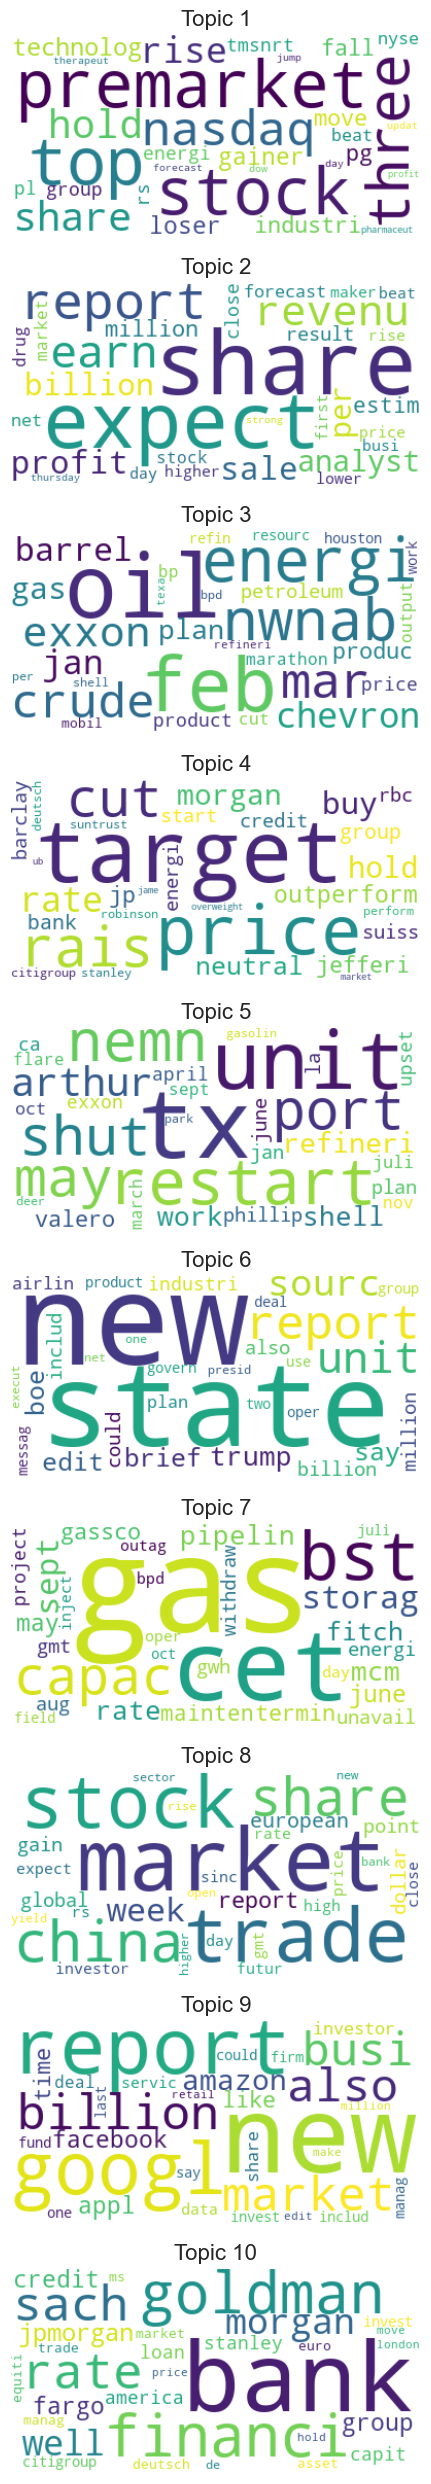

In [73]:
showWordclouds(10, df.columns)

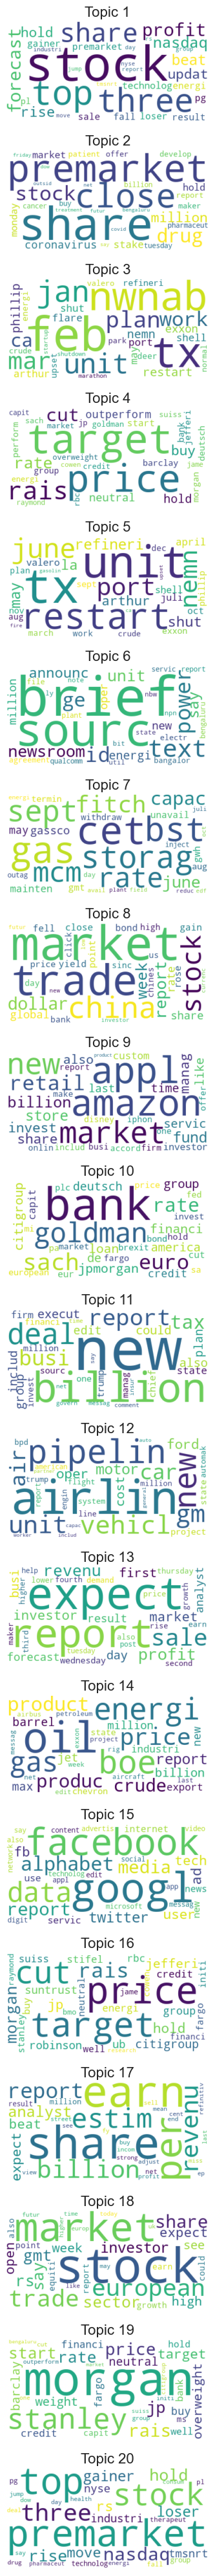

In [76]:
showWordclouds(20, df.columns, figsize=(80, 40))

In [117]:
def getTopicSimilarity(lda_model):
    topic_word_distributions = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
    similarity_matrix = cosine_similarity(topic_word_distributions)
    return similarity_matrix

<AxesSubplot: >

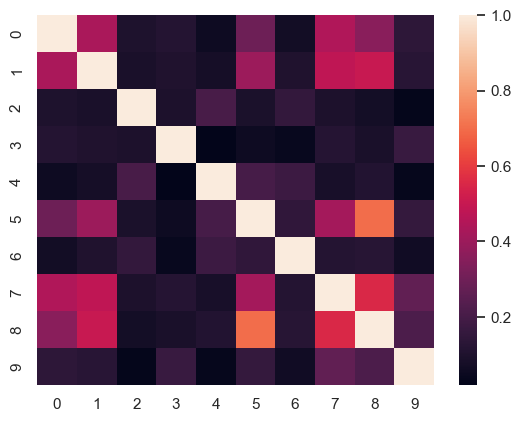

In [120]:
sns.heatmap(getTopicSimilarity(lda_10))

<AxesSubplot: >

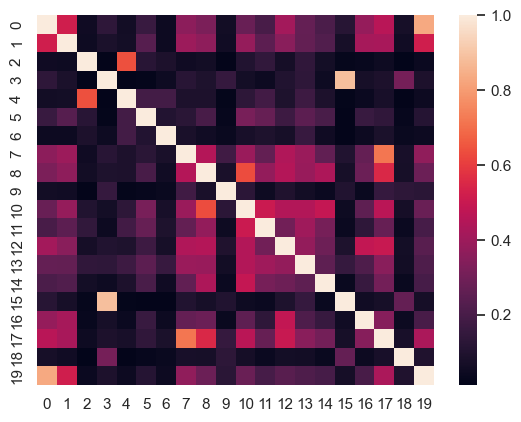

In [121]:
sns.heatmap(getTopicSimilarity(lda_20))

From the heatmap, we can see that the topic similarity of each topic model is not very high.

## (b)

In [108]:
i_t = pd.DataFrame(df.index.tolist(), columns=["permno", "trade_date"]) # used for concating

In [123]:
def topicRegression(num_topic, forcaste=False):

    lda_model = eval(f"lda_{num_topic}")
    topic_dist = lda_model.transform(df) # transform the matrix into a topic distribution matrix

    
    topic_list = [f"topic{i+1}" for i in range(num_topic)]
    # covert it to dataframe
    topic_dist = pd.DataFrame(topic_dist, columns = topic_list)
    topic_dist["permno"] = i_t["permno"]
    topic_dist["trade_date"] = i_t["trade_date"]

    reg_data = pd.merge(ret_data, topic_dist,
                    on = ["permno","trade_date"],
                    how = "right") # merge on topic varibales (10*1 or 20*1)
    reg_data['yearmon'] = (reg_data['trade_date'] 
                           - pd.tseries.offsets.MonthEnd(1)
                           + pd.tseries.offsets.MonthEnd(1))
    reg_data.set_index(['permno', 'yearmon'], inplace = True)
    
    # regress
    if forcaste:
        mod = PanelOLS.from_formula(
        formula = f"ret_tp1 ~ {' + '.join(topic_list)} + ret + ret_tm10_tm1 + EntityEffects + TimeEffects",
        data = reg_data
    )
        res_mod = mod.fit(cov_type='clustered', clusters=reg_data.trade_date)


    else:
        mod = PanelOLS.from_formula(
            formula = f"ret ~ {' + '.join(topic_list)} + ret_tm10_tm1 + EntityEffects + TimeEffects",
            data = reg_data
        )
        res_mod = mod.fit(cov_type='clustered', clusters=reg_data.trade_date)

    return res_mod

In [109]:
topicRegression(10)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LatentDirichletAllocation was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/linearmodels/panel/model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,ret,R-squared:,0.0019
Estimator:,PanelOLS,R-squared (Between):,-0.0395
No. Observations:,147467,R-squared (Within):,-0.0028
Date:,"Fri, Apr 21 2023",R-squared (Overall):,-0.0033
Time:,23:17:58,Log-likelihood,3.17e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,27.709
Entities:,605,P-value,0.0000
Avg Obs:,243.75,Distribution:,"F(10,146797)"
Min Obs:,1.0000,,
Max Obs:,1136.0,F-statistic (robust):,1.3551


In [110]:
topicRegression(20)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LatentDirichletAllocation was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/linearmodels/panel/model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,ret,R-squared:,0.0022
Estimator:,PanelOLS,R-squared (Between):,-0.0325
No. Observations:,147467,R-squared (Within):,-0.0025
Date:,"Fri, Apr 21 2023",R-squared (Overall):,-0.0031
Time:,23:18:14,Log-likelihood,3.17e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,16.520
Entities:,605,P-value,0.0000
Avg Obs:,243.75,Distribution:,"F(20,146787)"
Min Obs:,1.0000,,
Max Obs:,1136.0,F-statistic (robust):,2.1699


## (c)

In [124]:
topicRegression(10, forcaste=True)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LatentDirichletAllocation was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/linearmodels/panel/model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,ret_tp1,R-squared:,0.0067
Estimator:,PanelOLS,R-squared (Between):,-0.1127
No. Observations:,147443,R-squared (Within):,-0.0006
Date:,"Fri, Apr 21 2023",R-squared (Overall):,-0.0014
Time:,23:32:32,Log-likelihood,3.376e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,89.499
Entities:,604,P-value,0.0000
Avg Obs:,244.11,Distribution:,"F(11,146773)"
Min Obs:,1.0000,,
Max Obs:,1136.0,F-statistic (robust):,1.1761


In [125]:
topicRegression(20, forcaste=True)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LatentDirichletAllocation was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/linearmodels/panel/model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,ret_tp1,R-squared:,0.0072
Estimator:,PanelOLS,R-squared (Between):,-0.1250
No. Observations:,147443,R-squared (Within):,-0.0001
Date:,"Fri, Apr 21 2023",R-squared (Overall):,-0.0010
Time:,23:32:46,Log-likelihood,3.376e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,50.522
Entities:,604,P-value,0.0000
Avg Obs:,244.11,Distribution:,"F(21,146763)"
Min Obs:,1.0000,,
Max Obs:,1136.0,F-statistic (robust):,1.6148


What does it mean if there is a positive contemporaneous coefficient and negative predictive coefficient? If there is a positive contemporaneous and positive predictive coefficient？

* Positive contemporaneous coefficient & negative predictive coefficients imply investors overreact to news and created a reversal effect in the market that pushes the price to become lower.
* Positive contemporaneous & positive predictive coefficient imply the other side: market is less sensitive and might be underreact to news.